In [ ]:
from music21 import *
import copy, random, math

class MelodyModifier:
    def __init__(self, sc: stream.Score):
        '''
        Takes as input a path to a score
        '''
        self.sc = sc
        self.melody = self.sc.parts[0]
        self.melody.show()

    def mutate_melody(self, tonic: pitch.Pitch) -> stream.Part():
        '''
        given a melody, change it as appropriate. then return that melody.
        '''
        self.staccato_short(0.9)
        self.accent_downbeat()
        
        # self.double_note_frequency(tonic)
        self.elevate_repeats(tonic)
        
        self.rand_chords(tonic)
        
        self.chord_it(tonic)
        # self.grace_beginners(tonic)

    # Articulation modifications
    def staccato_short(self, min_dur: float):
        '''
        make all sufficiently-short notes in the melody staccato.
        '''
        for n in self.melody[note.Note]:
            if n.quarterLength <= min_dur:
                n.articulations += [articulations.Staccato()]
    def accent_downbeat(self):
        '''
        given a melody, accent every downbeat of the measures of the melody.
        '''
        for m in self.melody[stream.Measure]:
            for n in m[note.Note]:
                if n.offset == 0:
                    n.articulations += [articulations.Accent()]

    def grace_beginners(self, tonic: pitch.Pitch, offset_desired=2):
        '''
        given a melody, add a grace note to downbeat notes of measures
        '''
        sc = scale.MajorScale(tonic.name)
        for m in self.melody[stream.Measure]:
            for n in m[note.Note]:
                if n.offset == offset_desired:
                    grace_start = note.Note(sc.nextPitch(n.nameWithOctave))
                    grace = grace_start.getGrace()
                    m.insert(0, grace)
    
    # Involvement
    def double_note_frequency(self, tonic: pitch.Pitch):
        '''
        given a melody, change each note to have two notes, each with double the frequency
        '''
        for m in self.melody[stream.Measure]:
            for n in m[note.Note]:
                n.quarterLength *= 0.5
                n1 = copy.deepcopy(n)
                off = n.offset + n.quarterLength
                m.insert(off, n1)

    def elevate_repeats(self, tonic: pitch.Pitch, offset_mult=4):
        '''
        given a melody, for every note which starts a measure or a given offset
        multiplier (default 4: start of a 4/4 measure), change that note
        to have the next note up for the last 1/4 duration.
        
        Inspired by Country Gardens.
        
        C(4)-C(4) becomes C(3)-D(1)-C(4); parentheses illustrate durations.
        '''
        
        sc = scale.MajorScale(tonic.name)
        for m in self.melody[stream.Measure]:
            for n in m[note.Note]:
                if n.offset % offset_mult == 0:
                    dur = n.quarterLength
                    n.quarterLength = 0.75 * dur
                    add_note = note.Note(sc.nextPitch(n.nameWithOctave))
                    add_note.quarterLength = 0.25 * dur
                    m.insert(n.offset + 0.75*dur, add_note)

    def elevate_repeats(self, tonic: pitch.Pitch, offset_mult=4):
        '''
        given a melody, for every note which starts a measure or a given offset
        multiplier (default 4: start of a 4/4 measure), change that note
        to have the next note up for the last 1/4 duration.
        
        Inspired by Country Gardens.
        
        C(4)-C(4) becomes C(3)-D(1)-C(4); parentheses illustrate durations.
        '''
        
        sc = scale.MajorScale(tonic.name)
        for m in self.melody[stream.Measure]:
            for n in m[note.Note]:
                if n.offset % offset_mult == 0:
                    dur = n.quarterLength
                    n.quarterLength = 0.75 * dur
                    add_note = note.Note(sc.nextPitch(n.nameWithOctave))
                    add_note.quarterLength = 0.25 * dur
                    m.insert(n.offset + 0.75*dur, add_note)
    
    # Stacking
    def chord_it(self, tonic: pitch.Pitch, is_above=False):
        '''
        given a melody, take the first note of each measure and turn that into a chord
        '''
        sc = scale.MajorScale(tonic.name)
        for m in self.melody[stream.Measure]:
            for n in m[note.Note]:
                chord_notes = []
                if n.offset == 0:
                    pitch_nums = [2, 4, 7]
                    for i in range(3):
                        new_note = note.Note(sc.nextPitch(n.nameWithOctave, stepSize=pitch_nums[i]).nameWithOctave)
                        new_note.quarterLength = n.quarterLength
                        if not is_above:
                            new_note.octave -= 1 if new_note.name != n.name else 2
                        chord_notes.append(new_note)
                    new_chord = chord.Chord(chord_notes)
                    m.insertIntoNoteOrChord(0, new_chord)
    
    def rand_chords(self, tonic: pitch.Pitch, is_above=False, chord_density=0.15, note_density=0.6):
        '''
        allow random chords to accompany notes; this is specifically for non-downbeat chords
        '''
        sc = scale.MajorScale(tonic.name)
        for m in self.melody[stream.Measure]:
            for n in m[note.Note]:
                chord_notes = []             
                if n.offset != 0 and random.random() <= chord_density:
                    pitch_nums = [2, 4, 7]
                    for i in range(3):
                        if random.random() <= note_density:
                            new_note = note.Note(sc.nextPitch(n.nameWithOctave, stepSize=pitch_nums[i]).nameWithOctave)
                            new_note.quarterLength = n.quarterLength
                            if not is_above:
                                new_note.octave -= 1 if new_note.name != n.name else 2
                            chord_notes.append(new_note)
                    new_chord = chord.Chord(chord_notes)
                    m.insertIntoNoteOrChord(n.offset, new_chord)



In [ ]:
def beat_strength(offset: float) -> int:
    # Returns 2 if on 1, 3
    # 1 if on 2, 4
    # 0 if on +
    beat = math.floor(offset)
    decimal = offset - beat
    if decimal == 0:
        return 2 if beat in [0, 2] else 1
    else:
        return 0
    
def next_chord_tone(p: pitch.Pitch, ch: chord.Chord) -> pitch.Pitch:
    next_map = {
        ch.root().pitchClass: ch.third,
        ch.third.pitchClass: ch.fifth,
        ch.fifth.pitchClass: ch.root(),
    }
    res = next_map[p.pitchClass].transposeAboveTarget(p)
    if res.midi == p.midi:
        res.octave += 1
    return res

def prev_chord_tone(p: pitch.Pitch, ch: chord.Chord) -> pitch.Pitch:
    prev_map = {
        ch.root().pitchClass: ch.fifth,
        ch.third.pitchClass: ch.root(),
        ch.fifth.pitchClass: ch.third,
    }
    res = prev_map[p.pitchClass].transposeBelowTarget(p)
    if res.midi == p.midi:
        res.octave -= 1
    return res

def chord_tones_above(p: pitch.Pitch, ch: chord.Chord, k: int) -> list[pitch.Pitch]:
    '''
    Return the k chord tones above and including p.
    '''
    res = [p]
    for _ in range(k - 1):
        res.append(next_chord_tone(res[-1], ch))
    return res

In [53]:
class BassModifier:
    def __init__(self, sc: stream.Score):
        '''
        Takes as input a path to a score which contains the chord labels
        '''
        self.sc = sc
        self.bassline = self.sc.parts[1]
        self.key_sig = self.bassline[key.KeySignature].first()
        self.scale = self.key_sig.getScale('major')
        self.chords = {}
        self.notes = {}
        # TODO: music21 is very buggy with remove :|, so I just deduce the chords manually... 
        for n in self.bassline.flatten()[note.Note]:
            self.notes[n.offset] = n
            p = n.pitch
            self.chords[n.offset] = chord.Chord(
                [p, self.scale.nextPitch(p, stepSize=2), self.scale.nextPitch(p, stepSize=4)],
                duration=n.duration
            )
        self.measures = self.bassline[stream.Measure]
    
    
    def set_rhythm(self, n: note.Note, pattern: list[int]):
        '''
        Modifies a notes rhythm (where it is in a measure's context)
        '''
        d = n.quarterLength
        m = self.bassline.measure(n.measureNumber)
        curr_offset = n.offset # - m.offset
        # print("Starting at", offset, m.offset, n.measureNumber)
        denom = sum(pattern)
        for ix, amt in enumerate(pattern):
            new_d = amt / denom * d
            # print("Inserting", new_d, "at", curr_offset)
            if ix == 0:
                n.quarterLength = new_d
            else:
                new_n = note.Note(n.pitch, duration=duration.Duration(new_d))
                m.insert(curr_offset, new_n)
            curr_offset += new_d

    def inject_rhythm(self):
        '''
        For a loop of n chords, choose two patterns, one for first n-1, and a different
        one for the nth (to give rhythmic drive to the next loop)
        
        Currently, breaks into half-note divisions and provides one of the following
        distributions: 
        3:3:2, 3:1, 2:2, 1:1:1:1, 2:1:1, 1:1:2
        
        Operate on each half note first. Then organize which ones are special

        Todo: make more decisions on the weighting.
        '''
        # n = len(self.bassline.measures())
        # First pattern for the first n-1 measures
        weights = [4, 3, 3, 1, 3, 2]
        choices = [
            [3, 3, 2],
            [3, 1],
            [1, 1],
            [1, 1, 1, 1],
            [2, 1, 1],
            [1, 1, 2]
        ]
        rhythm_pattern = random.choices(choices, weights=weights, k=2)
        
        for m in self.measures[:-1]:
            for n in m[note.Note]:
                # Divide it by 2
                initial_split = [[1, 1], [1, 1], [2, 1, 1]]
                self.set_rhythm(n, random.choice(initial_split))
            for n in m[note.Note]:
                self.set_rhythm(n, rhythm_pattern[0])

        for n in self.measures[-1][note.Note]:
            self.set_rhythm(n, rhythm_pattern[1])
        
        self.bassline.show()

    def arpeggiate(self):
        '''
        Set more diverse pitches for the rhythms
        '''
        # Randomly shift by amounts. 
        weights = [4, 3, 2, 3, 1]
        choices = [
            0, 1, 2, 3, 4 # Root, 3rd, 5th, 8th, 10th for now.
        ]
        arpeggio_pattern = [0] + random.choices(choices, weights=weights, k=3)
        curr_chord = self.chords[0]
        chord_tones = chord_tones_above(curr_chord.root(), curr_chord, len(choices))
        pattern_pos = 0
        for m in self.measures:
            for n in m[note.Note]:
                curr_offset = m.offset + n.offset 
                if curr_offset in self.chords:
                    curr_chord = self.chords[curr_offset]
                    chord_tones = chord_tones_above(curr_chord.root(), curr_chord, len(choices))
                    pattern_pos = 0

                # TODO: Maybe consider strong vs weak beats?
                # Cycle through the pattern for the current chord
                n.pitch = chord_tones[arpeggio_pattern[pattern_pos]]
                pattern_pos = (pattern_pos + 1) % len(arpeggio_pattern)

                
    
    
    def thicken(self):
        '''
        Expand the notes to contain more chords, upwards
        '''
        # Randomly thicken
        weights = [5, 4, 5, 2]
        choices = [
            0, 1, 2, 3 # Allow stacking from 0 to 3 notes above the bass.
        ]
        thickness_pattern = random.choices(choices, weights=weights, k=4)
        curr_chord = self.chords[0] # Start with the root guaranteed
        chord_stack = chord_tones_above(curr_chord.root(), curr_chord, len(choices))
        pattern_pos = 0

        for m in self.measures:
            for n in m[note.Note]:
                curr_offset = m.offset + n.offset 
                if curr_offset in self.chords:
                    curr_chord = self.chords[curr_offset]
                    pattern_pos = 0

                thickness = thickness_pattern[pattern_pos]
                if thickness > 0:
                    chord_stack = chord_tones_above(n.pitch, curr_chord, len(choices))
                    stack = [chord_stack[1 + i] for i in range(thickness)]
                    if random.random() <= 0.1 * thickness:
                        stack.pop(0)
                    # print("Inserting at", n.offset, *m.getElementsByOffset(n.offset), n.pitch, stack)
                    m.insertIntoNoteOrChord(n.offset, chord.Chord(stack, quarterLength=n.quarterLength))

                pattern_pos = (pattern_pos + 1) % len(thickness_pattern)

    def insert_approach_tones(self):
        '''
        Override some of the previous rhythms with approach tones in front of new chords
        '''
        # Two main techniques:
        # Single or double approach chromatic.
        # Then, we can stack that by adding the current root
        return

    def mutate_bass(self):
        print("Injecting rhythm")
        self.inject_rhythm()
        self.show()
        print("Arpeggiating")
        self.arpeggiate()
        self.show()
        print("Thickening")
        self.thicken()


In [54]:
def fix_note_accidental(n: note.Note, key_sig: key.KeySignature):
    nStep = n.pitch.step
    rightAccidental = key_sig.accidentalByStep(nStep)
    n.pitch.accidental = rightAccidental

def fix_accidentals(sc: stream.Score):
    key_sig = sc.keySignature
    for n in sc[note.Note]: 
        fix_note_accidental(n, key_sig)
    for ch in sc[chord.Chord]:
        for n in ch.notes:
            fix_note_accidental(n, key_sig)

In [55]:
class MusicModifier:
    def __init__(self, sc: stream.Score):
        self.sc = sc
        self.bm = BassModifier(sc)
        self.mm = MelodyModifier(sc)
    
    def modify(self):
        tonic = bm.key_sig.asKey().tonic
        bm.mutate_bass()
        # mm.mutate_melody(tonic)
        bm.bassline.show()
        fix_accidentals(self.sc)

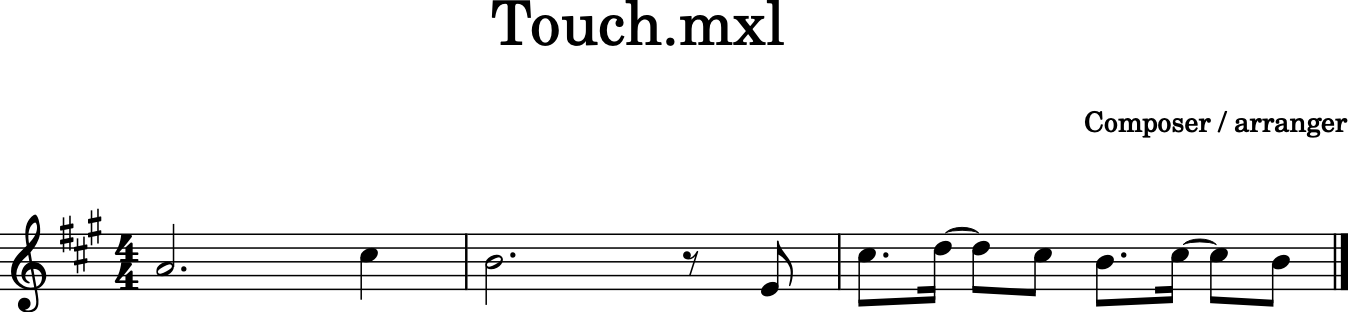

KeyboardInterrupt: 

In [56]:
score_dir = '/Users/derrick/PycharmProjects/MIT/21M_383/music-melody-generator/scores/'
piece = "Touch.mxl"
sc = converter.parse(score_dir + piece)
modifier = MusicModifier(sc)
modifier.modify()
sc.show()

In [ ]:
sc.show()

# Scaling the Hierarchy

Becuse parts cannot simply be concatenated to each other, we will need a few helper functions.

# Testing

We will test our function on pieces of different genres and see how they compare.

In [ ]:
key.KeySignature(3).asKey().tonic
